In [1]:
# Libraries
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import numpy as np

In [2]:
# Function to read the data
def read_mfcc_data(file_path):
    mfcc_blocks = []
    current_block = []
    with open(file_path, 'r') as file:
        # Iterates over each line in the file
        for line in file:
            
            # If the current block is finished, append it to the list of blocks
            if line.strip() == '':
                if current_block:
                    mfcc_blocks.append(current_block)
                    current_block = []
            else:
                # Convert each line to a list of floats (MFCC coefficients)
                frame = list(map(float, line.strip().split()))
                current_block.append(frame)
        # Append the last block if it ends without a blank line
        if current_block:
            mfcc_blocks.append(current_block)
    return mfcc_blocks

In [3]:
# Function to fit the GMM with KMeans
def fit_gmm(data, n_components=3):
    # Apply KMeans
    kmeans = KMeans(n_clusters=n_components, random_state=0)
    kmeans.fit(data)
    initial_means = kmeans.cluster_centers_
    
    # Apply GMM
    gmm_kmeans = GaussianMixture(n_components=n_components, covariance_type='full', means_init=initial_means, random_state=0)
    gmm_kmeans.fit(data)

    return gmm_kmeans

In [4]:
# Function to plot the GMM contours
def plot_gmm_contours(gmm, data, ax, dim1, dim2, fixed_dim, label):
    # Define grid limits
    x = np.linspace(np.min(data[:, dim1]), np.max(data[:, dim1]), 100)
    y = np.linspace(np.min(data[:, dim2]), np.max(data[:, dim2]), 100)
    X, Y = np.meshgrid(x, y)
    
    # Set fixed value for the third dimension
    fixed_value = np.mean(data[:, fixed_dim])
    XX = np.zeros((X.ravel().shape[0], 3))
    XX[:, dim1] = X.ravel()
    XX[:, dim2] = Y.ravel()
    XX[:, fixed_dim] = fixed_value

    # Compute density
    Z = -gmm.score_samples(XX)
    Z = Z.reshape(X.shape)

    # Plot contour and scatter points
    ax.contour(X, Y, Z, levels=10, cmap="viridis")
    ax.scatter(data[:, dim1], data[:, dim2], s=10, color='red', alpha=0.5, label='Data Points')
    ax.set_xlabel(f'MFCC {dim1 + 1}')
    ax.set_ylabel(f'MFCC {dim2 + 1}')
    ax.set_title(label)
    ax.legend()

In [5]:
# Make the actual plots
def plot_gmm_for_each_digit(mfcc_blocks, digit_start_indices, num_digits=10):
    for i in range(num_digits):
        block = np.array(mfcc_blocks[digit_start_indices[i]])
        data = block[:, :3]  # Select the first three MFCCs for each frame
        
        # Fit GMM model
        gmm = fit_gmm(data, n_components=3)

        # Create a new figure for each digit with 3 subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f'Digit {i} GMM Contour Plots')

        # Plot contours and points for each pair of MFCCs with the third MFCC fixed
        plot_gmm_contours(gmm, data, axes[0], dim1=0, dim2=1, fixed_dim=2, label='MFCC1 vs MFCC2')
        plot_gmm_contours(gmm, data, axes[1], dim1=0, dim2=2, fixed_dim=1, label='MFCC1 vs MFCC3')
        plot_gmm_contours(gmm, data, axes[2], dim1=1, dim2=2, fixed_dim=0, label='MFCC2 vs MFCC3')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


In [12]:
def plot_gmm_for_all_digits(mfcc_blocks, digit_start_indices, num_digits=10):
    # Create a grid with num_digits rows and 3 columns
    fig, axes = plt.subplots(nrows=num_digits, ncols=3, figsize=(18, 6 * num_digits))
    axes = axes.reshape(num_digits, 3)  # Ensure proper indexing for rows and columns
    
    for i in range(num_digits):
        # Extract data for the current digit
        block = np.array(mfcc_blocks[digit_start_indices[i]])
        data = block[:, :3]  # Select the first three MFCCs for each frame
        
        # Fit the GMM model
        gmm = fit_gmm(data, n_components=3)
        
        # Plot for each pair of MFCC dimensions
        for j, (dim1, dim2, fixed_dim) in enumerate([(0, 1, 2), (0, 2, 1), (1, 2, 0)]):
            ax = axes[i, j]  # Get the correct subplot
            x = np.linspace(np.min(data[:, dim1]), np.max(data[:, dim1]), 100)
            y = np.linspace(np.min(data[:, dim2]), np.max(data[:, dim2]), 100)
            X, Y = np.meshgrid(x, y)

            # Fix the third dimension
            fixed_value = np.mean(data[:, fixed_dim])
            XX = np.zeros((X.ravel().shape[0], 3))
            XX[:, dim1] = X.ravel()
            XX[:, dim2] = Y.ravel()
            XX[:, fixed_dim] = fixed_value

            Z = gmm.score_samples(XX)
            Z = Z.reshape(X.shape)

            # Plot the contours and scatter points
            ax.contour(X, Y, Z, levels=10, cmap="viridis")
            ax.scatter(data[:, dim1], data[:, dim2], s=10, color='red', alpha=0.5)
            ax.set_title(f'Digit {i} - MFCC{dim1 + 1} vs MFCC{dim2 + 1}')
            ax.set_xlabel(f'MFCC {dim1 + 1}')
            ax.set_ylabel(f'MFCC {dim2 + 1}')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()


In [13]:
# Reads the data
file_path = './data/Train_Arabic_Digit.txt'
mfcc_blocks = read_mfcc_data(file_path)

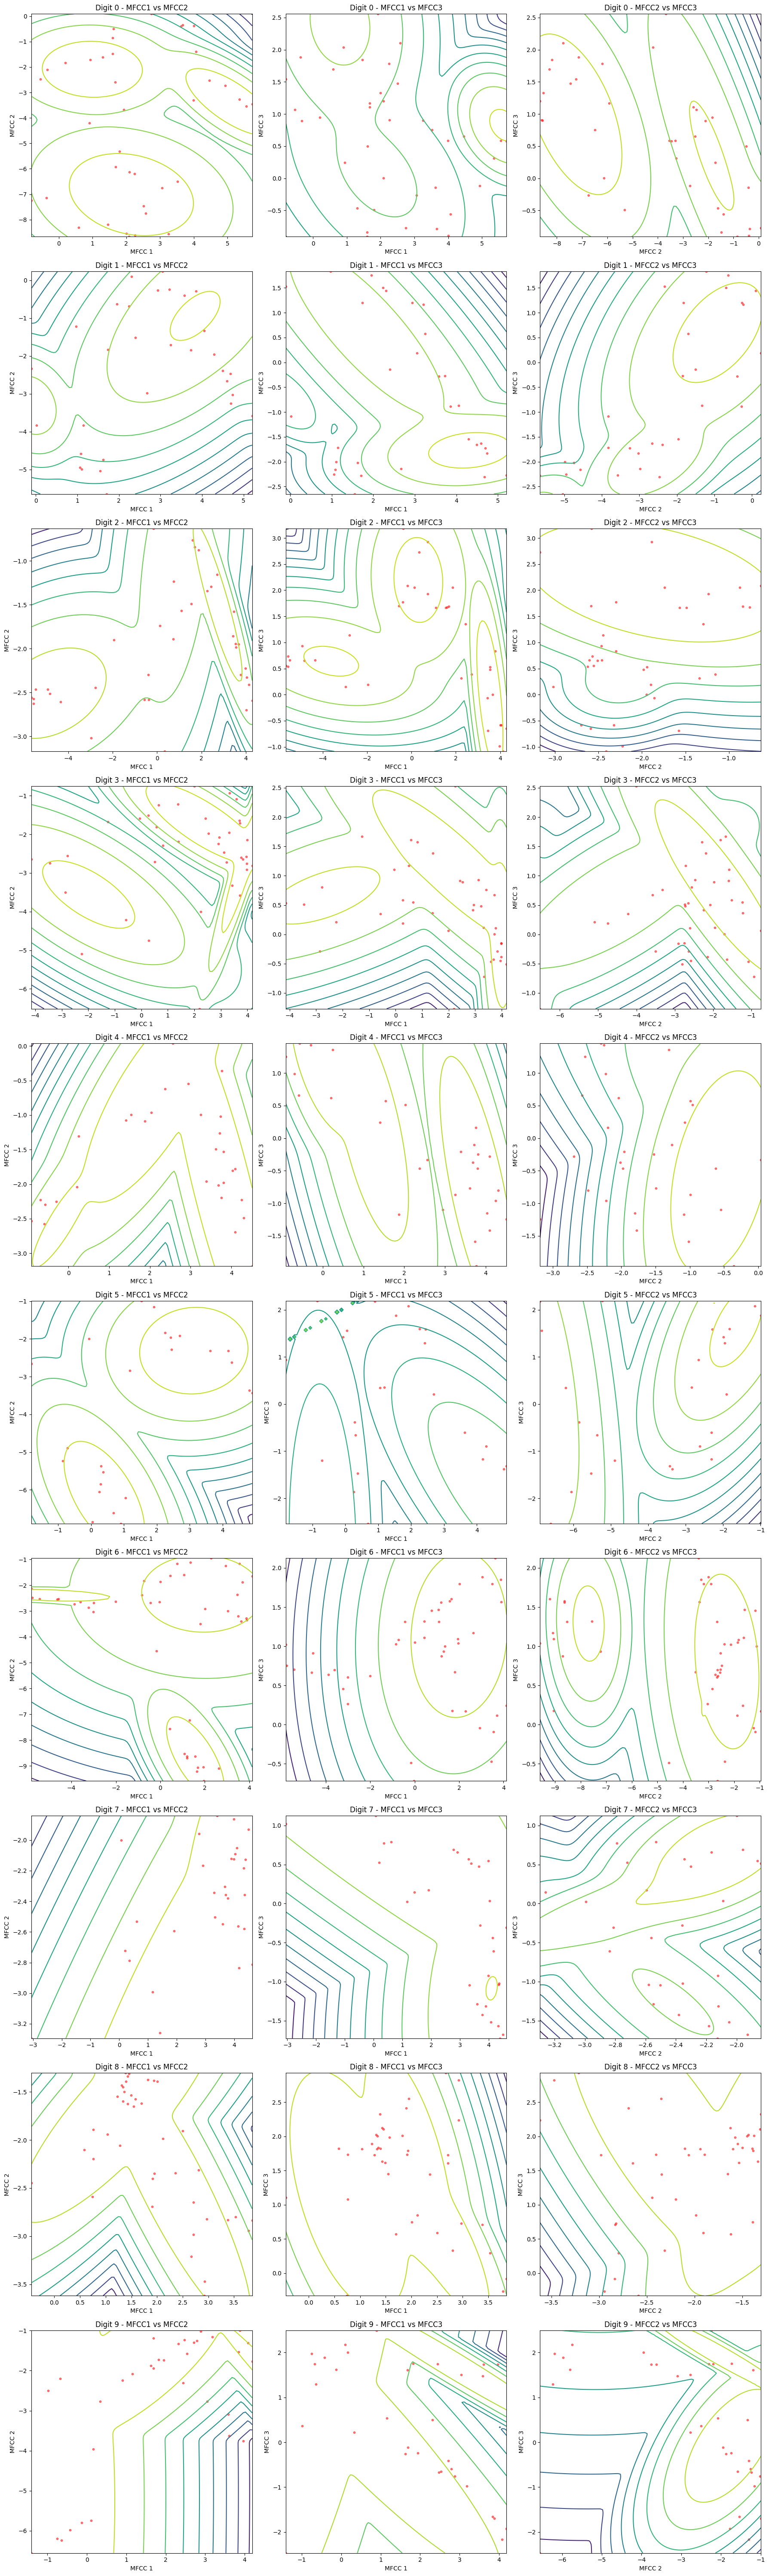

In [14]:
# Start indices for each of the digits
digit_start_indices = [0, 661, 1321, 1981, 2641, 3301, 3961, 4621, 5281, 5941]

# Make the plots
# plot_gmm_for_each_digit(mfcc_blocks=mfcc_blocks, digit_start_indices=digit_start_indices, num_digits=10)
plot_gmm_for_all_digits(mfcc_blocks=mfcc_blocks, digit_start_indices=digit_start_indices, num_digits=10)